In [1]:
import numpy as np
import pandas as pd
import contractions
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer

pd.set_option('display.max_colwidth', None)

In [2]:
p1_df = pd.read_csv("./transcripts/mrs-r.csv")
p1_df.drop(p1_df[p1_df["Transcript"].str.startswith("Taylor: ")].index, inplace=True)

p1_df["Transcript"] = p1_df["Transcript"].apply(lambda x: re.sub("Mrs\.?\s+R\s*:\s*", "", x))
p1_df["Transcript"] = p1_df["Transcript"].apply(lambda x: contractions.fix(x))

p1_df.head()

,Transcript,Codes
1,"First of all, I still have a strong voice at the age of 90, so a lot of people on the phone do not think I am 90, but this year I am 90 and I have lived in Santa Clara Valley, which is now called Silicon Valley, oh, most of my life. It is a wonderful place to live. Wonderful weather. Close to the ocean. So that is where I grew up and it was a, I grew up in a town of Santa Clara, which was right next to San Jose, and it was a town of 5,000 people at the time. Very low key, very nice place to grow up. It was able to ride my bicycle all over the place. Had a lot of freedom. So that is me.","Code 1: City of origin, Code 2: Childhood, Code 3: Freedom, Code 4: Bicycling"
3,"You know something, I do not think I would take you up on that. Because you know, life is a real mixture and there is wonderful, and there is some things you do not want to live agains. So, um, I think my childhood was very, very happy. I had a happy life so, I really do not know that I would want to live any of my years again. They were, I had wonderful times raising our children. We decided to have a large family and so we ended up with six daughters and four sons and they are all alive and doing well today. Very proud of them. And, uh, our son, Toby, is living at Pittsburgh and he has a daughter named Taylor who is doing this podcast. So that is where I am at.","Code 2: Childhood, Code 5: Parenting, Code 6: Positive family relationships, Code 7: Children, Code 8: Happiness, Code 9: Contentment, Code 10: Pride"
5,"If you could speak to your younger self, what advice would you give? Hmm. Well, I do not, it was really interesting. When I was growing up, there were three choices for women. To work as a job, a secretary, nurse, or teacher. And none of those appealed to me at my young age. And so when I met my husband to be, he had gotten out of the service. Second World War was over and he had.","Code 11: Different expectations, Code 12: Societal expectations, Code 13: Gender roles, Code 14: Post-war America, Code 15: Spouse,"
6,"Something called the GI Bill, which was a wonderful bill that they put through Congress, which allowed any service man to go to college for free. For free. It was wonderful. So he, what he did is he came out here and he ended up going to Santa Clara University and he only had had two years before the war was ended, but they let him stay for four years and he got his education and we got married during that time and that was a really good decision.","Code 15: Spouse, Code 16: College, Code 17: Social programs, Code 18: Marriage, Code 19: Gratitude"
7,"I went to college for one year, and then I was a mom and I really loved being a mom. So we had numerous children and they were all very active doing things, making things, being active. Boys all had paper routes and had a little bit of money that way, and the girls did a lot of babysitting and a lot of sewing, and a lot of helping canning fruit.","Code 16: College, Code 5: Parenting, Code 8: Happiness, Code 9: Contentment, Code 7: Children, Code 20: Sewing, Code 21: Canning, Code 22: Being active"


In [3]:
# 1 document =  1 paragraph
docs = p1_df["Transcript"].to_list()

# Create embeddings
embedding_model = SentenceTransformer("all-mpnet-base-v2")
embeddings = embedding_model.encode(docs)

# Dimensionality reduction
umap_model = UMAP(n_neighbors=5, n_components=2, metric="cosine", random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)

# Document clustering
hdbscan_model = HDBSCAN(min_cluster_size=5, metric="euclidean", prediction_data=True)

# Clustered documents tokenization
cv_model = CountVectorizer(stop_words="english")

# Topic representation
ctfidf_model = ClassTfidfTransformer()

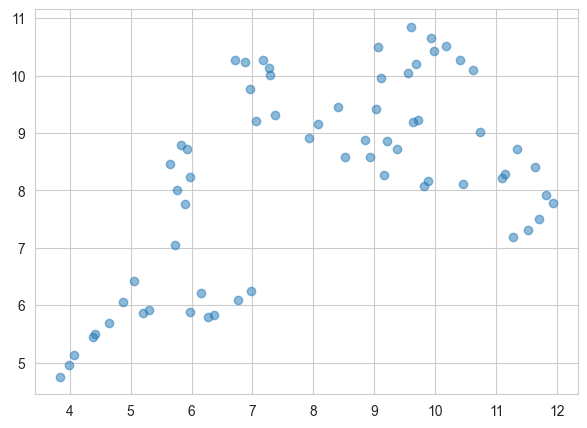

In [4]:
# Plot documents in latent space
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1], alpha=0.5)
plt.show()

In [6]:
seed_topics = [["spouse", "marriage", "family"],
               ["food", "ww2", "relationships"],
               ["social programs", "depression", "politics"],
               ["travel", "adventurous"]]

topic_model = BERTopic(umap_model=umap_model,
                       hdbscan_model=hdbscan_model,
                       vectorizer_model=cv_model,
                       ctfidf_model=ctfidf_model,
                       seed_topic_list=seed_topics,
                       calculate_probabilities=True)

topic, probs = topic_model.fit_transform(docs)

topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings, hide_annotations=True)

In [7]:
topic_model.visualize_barchart(n_words=10, height=300, width=325)

In [8]:
def jaccard_index(key1: list, key2: list) -> float:
    n = set(key1).intersection(key2)
    d = set(key1).union(key2)

    return len(n)/len(d)

human_codes = ["Code 15: Spouse", "Code 41: Food", "Code 17: Social Programs", "Code 26: Travel", "Code 32: Social Connections"]

doc_df = p1_df
scores = []

for hc in human_codes:
    code_df = doc_df[doc_df["Codes"].str.contains(hc, na=False)]
    doc = code_df["Transcript"].to_list()

    code_dtm = cv_model.fit_transform(doc)
    vocab = cv_model.get_feature_names_out()
    counts = code_dtm.toarray().sum(axis=0)

    top_n_df = pd.DataFrame({"Vocab": vocab, "Counts": counts})
    top_n_df.sort_values(by="Counts", ascending=False, inplace=True)
    a = top_n_df["Vocab"].head(10)
    hc_score = []

    # TODO vectorize
    for i in range(len(topic_model.get_topics())-1):
        b = list(map(lambda x: x[0], topic_model.get_topic(i)))
        score = jaccard_index(a,b)
        hc_score.append(score)

    scores.append(hc_score)


<Axes: >

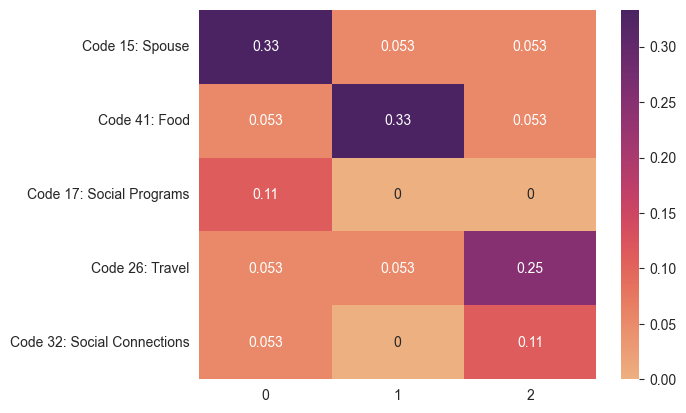

In [13]:
sns.heatmap(scores, annot=True, yticklabels=human_codes,cmap=sns.color_palette("flare", as_cmap=True))

In [10]:
topic_model.visualize_barchart(n_words=10, height=300, width=325)

In [233]:
# Comparison metric - Jaccard index

code = "Code 15: Spouse"
code_df = p1_df[p1_df["Codes"].str.contains(code, na=False)]
code_doc = code_df["Transcript"].to_list()

code_dtm = cv_model.fit_transform(code_doc) # 12 x 196
vocab = cv_model.get_feature_names_out()
counts = code_dtm.toarray().sum(axis=0)

top_n_df = pd.DataFrame({"Vocab": vocab, "Counts": counts})
top_n_df.sort_values(by="Counts", ascending=False, inplace=True)
top_n_df.reset_index().head(10)

top_n = top_n_df["Vocab"].head(10)
top_n

86       husband
166       things
78        having
186    wonderful
167        think
46           did
109      married
68           got
172         took
138       really
Name: Vocab, dtype: object

In [318]:
# VECTORIZING
topic_num = len(topic_model.get_topics()) - 1

test = list(topic_model.get_topics().values())[1:]
test[:][0][:]
# vocab = list(map(lambda x: x[:][:][0], test))
# vocab

[('think', 0.05801264674935088),
 ('wonderful', 0.052987501523378666),
 ('things', 0.048778424238730925),
 ('really', 0.044835578212089645),
 ('lot', 0.044089655306935614),
 ('fun', 0.04130029229804329),
 ('did', 0.03977238570246731),
 ('years', 0.03671137093159403),
 ('doing', 0.03513712748441838),
 ('life', 0.034280574016650245)]